# Brain Tumor Detection with SyMPC - [v2]
### Oleksandr Lytvyn
dataset: https://www.kaggle.com/navoneel/brain-mri-images-for-brain-tumor-detection


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
import torch.optim as optim
import torchvision.transforms as transforms
from sklearn.utils import shuffle
from PIL import Image
import syft as sy
%matplotlib inline

device = torch.device('cpu')
# training on GPU in not awailable right now

torch.manual_seed(1)

In [2]:
from glob import glob
class BrainMRIDataset(Dataset):

    def __init__(self,data_dir,reshape=True,height=128,width=128, transform=None):
        self.dataDirectory = data_dir
        self.no_class = glob(data_dir+'/no/*')
        self.yes_class = glob(data_dir+'/yes/*')
        self.height = height
        self.width = width
        self.reshape=reshape
        self.transform = transform

        labels = [0 for i in range(len(self.no_class))]
        labels += [1 for i in range(len(self.yes_class))]

        image_links = self.no_class + self.yes_class
        self.dataframe = pd.DataFrame({
            'image':image_links,
            'labels': labels
        })

        self.dataframe = shuffle(self.dataframe)
        self.dataframe.reset_index(inplace=True,drop=True)

    def __len__(self):
        return len(self.no_class)+len(self.yes_class)

    def __getitem__(self,idx):

        image = self.dataframe['image'][idx]
        label = self.dataframe['labels'][idx]

        image = Image.open(image).convert("L")

        if self.reshape:
            image = image.resize((self.height,self.width))

        array = np.asarray(image)
        if self.transform:
            array = self.transform(array)
#             print(type(array))
        
        array = array.reshape(1, self.height,self.width)

#         print(type(array))
        image = torch.tensor(array)
        label = torch.tensor(label)

        return [image,label]

    def __repr__(self):
        return str(self.dataframe.head())


In [3]:
# transformations = transforms.Compose([
#     transforms.ToPILImage(),
#     transforms.RandomChoice([
#         transforms.ColorJitter(brightness=1),
#         transforms.RandomRotation(degrees=45),
#         transforms.RandomHorizontalFlip(),
#         transforms.RandomVerticalFlip(),
#         transforms.RandomGrayscale(p=0.1)
#     ]),
#     transforms.ToTensor()
#     # transforms.Normalize(mean=[0.0,0.0,0.0], std=[1.0,1.0,1.0]) normalize images
# ])

# color_transformations = transforms.Compose([
#     transforms.ToPILImage(),
#     transforms.RandomChoice([
#         transforms.ColorJitter(brightness=0.4),
#         transforms.ColorJitter(brightness=0.5),
#         transforms.ColorJitter(brightness=0.6),
#         transforms.ColorJitter(brightness=0.7)
#     ]),
#     transforms.ToTensor()
# ])

rotation_transformations = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomChoice([
        transforms.RandomRotation(degrees=30),
        transforms.RandomRotation(degrees=25),
        transforms.RandomRotation(degrees=20),
        transforms.RandomRotation(degrees=15)
    ]),
    transforms.ToTensor()
])

flip_transformations = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomChoice([
        transforms.RandomHorizontalFlip(p=1),
        transforms.RandomVerticalFlip(p=1),
        transforms.Compose([
            transforms.RandomHorizontalFlip(p=1),
            transforms.RandomVerticalFlip(p=1)
        ])
    ]),
    transforms.ToTensor()
])

grayscale_transformations = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomChoice([
        transforms.Grayscale(),
        transforms.RandomPerspective(distortion_scale=.1, p=1)
    ]),
    transforms.ToTensor()
])

In [4]:
#upload data
path_to_project_root = '../../../'
data_dir = path_to_project_root + 'data/brain_tumor_imgs'
dataset = BrainMRIDataset(data_dir, height=64, width=64, transform=None) + \
          BrainMRIDataset(data_dir, height=64, width=64, transform=rotation_transformations) + \
          BrainMRIDataset(data_dir, height=64, width=64, transform=flip_transformations)
#           BrainMRIDataset(data_dir, height=64, width=64, transform=grayscale_transformations)
print(dataset)

683, 76


<ipython-input-2-2e16d5b9921f>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(array)


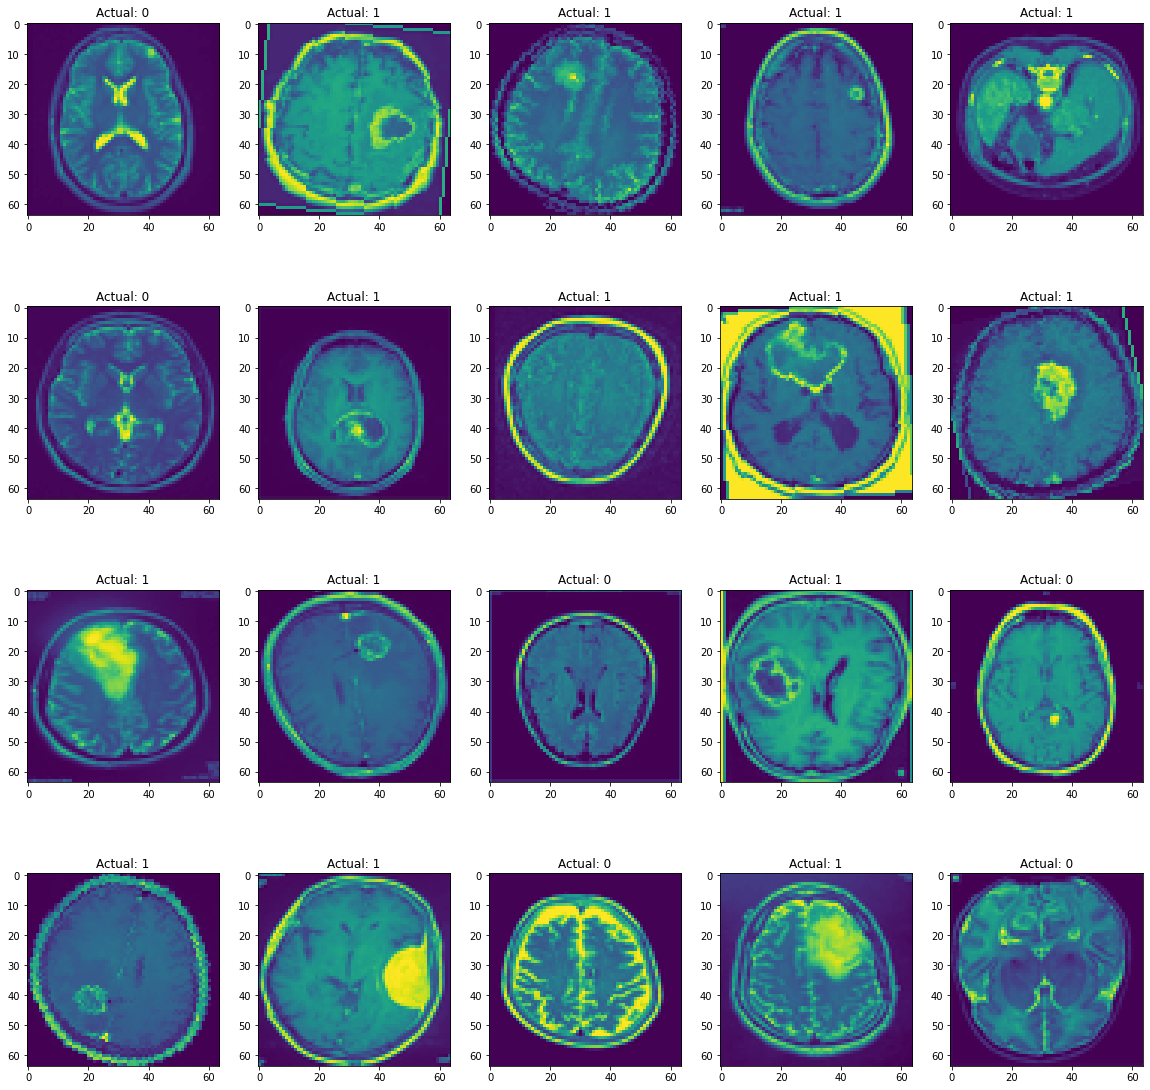

In [5]:
datasetsize = len(dataset)
train_size = int(datasetsize * 0.9)
test_size = datasetsize - train_size

train_data, test_data = torch.utils.data.random_split(dataset, [train_size, test_size])
print(f"{len(train_data)}, {len(test_data)}")


fig = plt.figure(figsize=(20,20))
for i in range(20):
    target = train_data[i][1]
    plt.subplot(4,5, i+1)
    plt.imshow(train_data[i][0][0])
    plt.title(f'Actual: {target}')
plt.show()


#### MODEL with SyMPC wraper

In [6]:
class BrainTumorModel(sy.Module):
    def __init__(self, torch_ref):
        super(BrainTumorModel, self).__init__(torch_ref=torch_ref)
        self.conv1 = self.torch_ref.nn.Conv2d(1, 128, kernel_size=3)
        self.conv2 = self.torch_ref.nn.Conv2d(128,32,kernel_size=2)
        self.linear1 = self.torch_ref.nn.Linear(30,64)
        self.linear2 = self.torch_ref.nn.Linear(64,32)
        self.flat = self.torch_ref.nn.Flatten(1)
        self.linear3 = self.torch_ref.nn.Linear(30720,2)

    def forward(self,x):
        x = self.conv1(x)
        x = self.torch_ref.nn.functional.max_pool2d(x,2)
        x = self.conv2(x)
        x = self.torch_ref.nn.functional.relu(x)
        x = self.linear1(x)
        x = self.torch_ref.nn.functional.relu(x)
        x = self.linear2(x)
        x = self.flat(x)
        x = self.linear3(x)

        return x

In [7]:
model = BrainTumorModel(torch_ref=torch)
print(model)

In [8]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 100
plot = False

def test(model, test_loader, loss_fn):
    test_loss = 0
    accuracy = 0
    number_of_imags = len(test_loader)
    for image, label in test_loader:
        pred = model.forward(image.float())
        test_loss += loss_fn(pred, label).item()
        pred = torch.argmax(pred, dim=1)

        equality = (label.data == pred)
        accuracy += equality.type(torch.FloatTensor).mean()
        
    return test_loss/number_of_imags, accuracy/number_of_imags


def train(model, train_data, test_data, num_epochs = 100, batch_size = 32):
    train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(dataset=test_data, batch_size=batch_size)
    model.train()
    loss_list = []
    for epoch in range(num_epochs):
        total_loss = 0
        i=0
        for batch in train_loader:
            optimizer.zero_grad()
            image, label = batch
            images_batch = Variable(image)
            labels_batch = Variable(label)
            output = model(images_batch.float())
            loss = loss_fn(output, labels_batch)
            total_loss += loss
            loss.backward()
            optimizer.step()
            i+=1
        if epoch%10 == 0:
            test_loss, accuracy = test(model, test_loader, loss_fn)
            print(f'Epochs: {epoch} Loss: {total_loss/i: .4f}, Accuracy: {accuracy: .4f}')
#             print('-----------------------------------------------')
        loss_list.append(total_loss/batch_size)
    return loss_list

In [9]:
loss_list = train(model, train_data, test_data, num_epochs=num_epochs)

loss_list = [loss_item.detach() for loss_item in loss_list]

if plot:
    fig = plt.figure(figsize=(10,10))
    plt.plot(list(range(num_epochs)),loss_list)
    plt.title("Loss v/s Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.show()

<ipython-input-2-2e16d5b9921f>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(array)


Epochs: 0 Loss:  1.6398, Accuracy:  0.7535
Epochs: 10 Loss:  0.3690, Accuracy:  0.8125
Epochs: 20 Loss:  0.2443, Accuracy:  0.9306
Epochs: 30 Loss:  0.2174, Accuracy:  0.8785
Epochs: 40 Loss:  0.1077, Accuracy:  0.8785
Epochs: 50 Loss:  0.0341, Accuracy:  0.8819
Epochs: 60 Loss:  0.0356, Accuracy:  0.9167
Epochs: 70 Loss:  0.0175, Accuracy:  0.8819
Epochs: 80 Loss:  0.0605, Accuracy:  0.8507
Epochs: 90 Loss:  0.0950, Accuracy:  0.8681


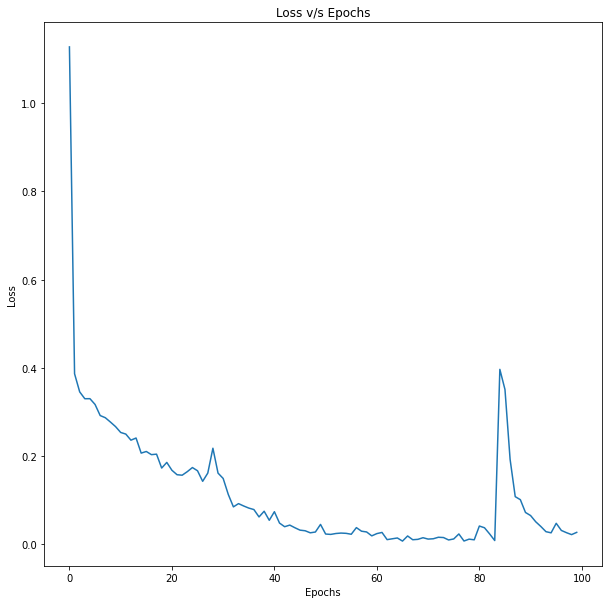

In [10]:
fig = plt.figure(figsize=(10,10))
plt.plot(list(range(num_epochs)),loss_list)
plt.title("Loss v/s Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

In [11]:
#Evaluate model

def test(model, test_loader, loss_fn):
    test_loss = 0
    accuracy = 0
    number_of_imags = len(test_loader)
    for image, label in test_loader:
        pred = model.forward(image.float())
        test_loss +=loss_fn(pred, label).item()
        pred = torch.argmax(pred, dim=1)

        equality = (label.data == pred)
        accuracy += equality.type(torch.FloatTensor).mean()
    print(f'Test Accuracy: {accuracy/number_of_imags:.2f} \n'
          f'Test Loss: {test_loss/len(image): .2f}')
    return test_loss, accuracy

test_loader = DataLoader(test_data, batch_size=32, shuffle=True)
test(model, test_loader, loss_fn)

<ipython-input-2-2e16d5b9921f>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(array)


Test Accuracy: 0.86 
Test Loss:  0.17


(2.027811039239168, tensor(2.5938))

tensor([[-6.1169,  6.1689]], grad_fn=<AddmmBackward>)
tensor([[-2.1549,  2.2162]], grad_fn=<AddmmBackward>)
tensor([[-9.4776,  9.5247]], grad_fn=<AddmmBackward>)
tensor([[-2.9656,  2.9910]], grad_fn=<AddmmBackward>)
tensor([[ 6.0236, -6.0060]], grad_fn=<AddmmBackward>)
tensor([[-0.5379,  0.5164]], grad_fn=<AddmmBackward>)


<ipython-input-2-2e16d5b9921f>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(array)


tensor([[-5.2599,  5.4112]], grad_fn=<AddmmBackward>)
tensor([[ 9.0951, -8.9791]], grad_fn=<AddmmBackward>)
tensor([[-8.6837,  8.7630]], grad_fn=<AddmmBackward>)
tensor([[-6.3333,  6.2736]], grad_fn=<AddmmBackward>)
tensor([[-0.7304,  1.7095]], grad_fn=<AddmmBackward>)
tensor([[ 2.6084, -2.4847]], grad_fn=<AddmmBackward>)
tensor([[ 10.6477, -10.2521]], grad_fn=<AddmmBackward>)
tensor([[ 4.1085, -4.2200]], grad_fn=<AddmmBackward>)
tensor([[-8.3471,  8.8916]], grad_fn=<AddmmBackward>)
tensor([[-0.5688,  0.5659]], grad_fn=<AddmmBackward>)
tensor([[-8.9452,  8.8984]], grad_fn=<AddmmBackward>)
tensor([[-1.9742,  2.0162]], grad_fn=<AddmmBackward>)
tensor([[-4.0511,  4.1939]], grad_fn=<AddmmBackward>)
tensor([[ 5.9173, -6.2603]], grad_fn=<AddmmBackward>)


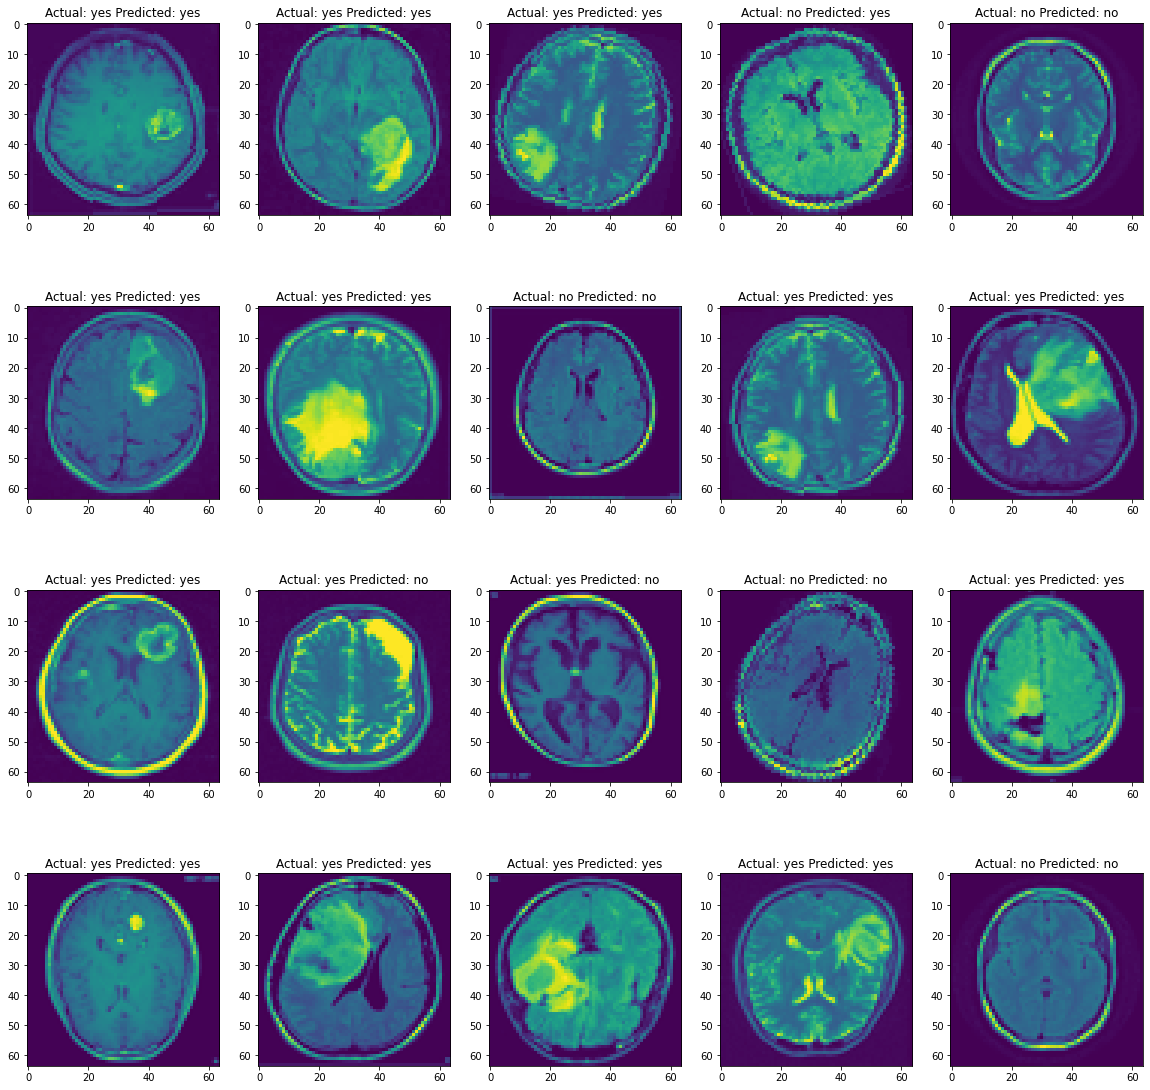

actual accuracy:  0.85


In [12]:
plot_loader = DataLoader(test_data, batch_size=1)

mapping = {0:'no',1:'yes'}
fig = plt.figure(figsize=(20,20))
i = 0
correct = 0
raw_predictions = []
for img, lbl in plot_loader:
    if i == 20: break
    pred = model(img.float())
    print(pred)
    pred = torch.argmax(pred,dim=1)
    raw_predictions.append(pred)
    plt.subplot(4,5,i+1)
    plt.imshow(img[0][0].cpu())
    if lbl == pred: correct += 1
    plt.title(f'Actual: {mapping[lbl.cpu().detach().item()]} Predicted: {mapping[pred.cpu().detach().item()]}')
    i+=1
plt.show()
print(f"actual accuracy: {correct/i: .2f}")

In [15]:
raw_predictions

[tensor([1]),
 tensor([1]),
 tensor([0]),
 tensor([1]),
 tensor([1]),
 tensor([0]),
 tensor([1]),
 tensor([0]),
 tensor([1]),
 tensor([1]),
 tensor([0]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([0]),
 tensor([1]),
 tensor([1]),
 tensor([1])]

### SyMPC part


In [13]:
import sympc
from sympc.session import Session
from sympc.session import SessionManager
from sympc.tensor import MPCTensor
from sympc.protocol import FSS
from sympc.protocol import Falcon

In [29]:
def get_clients(n_parties):
  #Generate required number of syft clients and return them.

  parties=[]
  for index in range(n_parties):
      parties.append(sy.VirtualMachine(name = "worker"+str(index)).get_root_client())

  return parties

def split_send(data,session):
    """Splits data into number of chunks equal to number of parties and distributes it to respective
       parties.
    """
    image_pointers = []

#     split_size = int(len(data)/len(session.parties))+1
    split_size = int(len(data)/len(session.parties))


    for index in range(0,len(session.parties)):
#         ptr=data[index*split_size:index*split_size+split_size].share(session=session)
        ptr=data[index*split_size:index*split_size+split_size]
        image_pointers.append(MPCTensor(secret=ptr, session=session))

    return image_pointers

In [15]:
#creating parties and session
parties = get_clients(2)
session = Session(parties=parties)
SessionManager.setup_mpc(session)


In [20]:
# default split data
ptrs = []
labels = []
for i, (img, lbl) in enumerate(plot_loader):
    if i == 10: break
    img_f = img.type(torch.float32)
    ptrs.append(MPCTensor(secret=img_f,session=session, requires_grad=True))
    labels.append(lbl)   
len(ptrs)



<ipython-input-3-2e16d5b9921f>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(array)


10

In [25]:
ptrs

[[MPCTensor]
 Shape: torch.Size([1, 1, 64, 64])
 Requires Grad: True
 	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
 	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer,
 [MPCTensor]
 Shape: torch.Size([1, 1, 64, 64])
 Requires Grad: True
 	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
 	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer,
 [MPCTensor]
 Shape: torch.Size([1, 1, 64, 64])
 Requires Grad: True
 	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
 	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer,
 [MPCTensor]
 Shape: torch.Size([1, 1, 64, 64])
 Requires Grad: True
 	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
 	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer,
 [MPCTensor]
 Shape: torch.Size([1, 1, 64, 64])
 Requires Grad: True
 	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
 	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer,


In [21]:
mpc_model = model.share(session)
mpc_model

In [22]:
#Perform inference and measure time taken
import time
start_time = time.time()

results = []

for ptr in ptrs:
    encrypted_results = mpc_model(ptr)
    print(f"encrypted results: {encrypted_results}")
    plaintext_results = encrypted_results.reconstruct()
    print(f"plain text results: {plaintext_results}")
    results.append(plaintext_results)

end_time = time.time()
results

[2021-11-18T14:34:58.082970+0000][CRITICAL][logger]][13223] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 6b07c91bb049413fb9e949fd244cd408>.
[2021-11-18T14:34:58.094749+0000][CRITICAL][logger]][13223] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 07fa78df896e4f9bbd75618763c0409a>.
[2021-11-18T14:36:02.456068+0000][CRITICAL][logger]][13223] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 94adeee4f65b42a58399126f02fc74e7>.
[2021-11-18T14:36:02.465224+0000][CRITICAL][logger]][13223] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 3c71d74d93f24a729836116ea5e9f6be>.
[2021-11-18T14:36:32.302330+0000][CRITICAL][logger]][13223] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: cdee1cb8e8794cb49a682ea8c7d78449>.
[2021-11-18T14:36:32.305707+0000][CRITICAL][logger]][13223] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 5fe8e08dd172408

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-5.5364,  5.6305]])


[2021-11-18T14:36:39.285166+0000][CRITICAL][logger]][13223] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: e31116927ca44af9a371be510fdd6d7c>.
[2021-11-18T14:36:39.290059+0000][CRITICAL][logger]][13223] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 151ae99f233c4bd0b28a7b49ae52ae93>.
[2021-11-18T14:36:39.302302+0000][CRITICAL][logger]][13223] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: fce347c92daf4ecaa2791a1309df7ac0>.
[2021-11-18T14:36:39.307069+0000][CRITICAL][logger]][13223] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 4a33052531144eaf882a2b26e4b7c1be>.
[2021-11-18T14:36:39.320463+0000][CRITICAL][logger]][13223] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 0f701540c2244762b9f87e6ad151ca8d>.
[2021-11-18T14:36:39.323244+0000][CRITICAL][logger]][13223] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 885b9653701e43a

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[13.6009,  0.2782]])


[2021-11-18T14:38:25.532220+0000][CRITICAL][logger]][13223] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 8eed01dc496a4cdc8516388f0e2067a4>.
[2021-11-18T14:38:25.543869+0000][CRITICAL][logger]][13223] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 7824eef9e48f41fd8124128bda6c7dd1>.
[2021-11-18T14:38:25.551940+0000][CRITICAL][logger]][13223] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 05101102f8554ec196f57b7c207f5829>.
[2021-11-18T14:38:25.554563+0000][CRITICAL][logger]][13223] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 4c3b4a37b26044a4811dd4ba2040f623>.
[2021-11-18T14:38:25.726959+0000][CRITICAL][logger]][13223] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 2c479a24fbb548f88bcaeb6379f802ff>.
[2021-11-18T14:38:25.729676+0000][CRITICAL][logger]][13223] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 06bc5a848c7d4d3

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 3.0216, -3.0240]])


[2021-11-18T14:40:12.928342+0000][CRITICAL][logger]][13223] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 9263816dfdb54e6aa39b151239de3710>.
[2021-11-18T14:40:12.942054+0000][CRITICAL][logger]][13223] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 22cba644c74040f6b634a2a75cddf2c0>.
[2021-11-18T14:40:12.966980+0000][CRITICAL][logger]][13223] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: dfb4e71840954713a3e1d717e868e603>.
[2021-11-18T14:40:12.970051+0000][CRITICAL][logger]][13223] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: be1219eec4d64e36bb9c08aa61bfec76>.
[2021-11-18T14:40:12.974513+0000][CRITICAL][logger]][13223] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 8ba3ef476c774cdf968636de1605eb71>.
[2021-11-18T14:40:12.977281+0000][CRITICAL][logger]][13223] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 8f76a690b31f42f

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-4.4637,  4.4549]])


[2021-11-18T14:42:02.042280+0000][CRITICAL][logger]][13223] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 0af9f2f3daf14734ab76d5897b6f9072>.
[2021-11-18T14:42:02.053948+0000][CRITICAL][logger]][13223] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 9918c25f94b24581badc51986dd8559e>.
[2021-11-18T14:42:02.070944+0000][CRITICAL][logger]][13223] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: bc20567a51954203aeefc9973c2e550f>.
[2021-11-18T14:42:02.073866+0000][CRITICAL][logger]][13223] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 1096c4fe593d4d10934d93e134d20805>.
[2021-11-18T14:42:02.082423+0000][CRITICAL][logger]][13223] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 6010ae6f9a7a4d8186f2ce77644101b4>.
[2021-11-18T14:42:02.084838+0000][CRITICAL][logger]][13223] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: a45cc2314608490

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-9.1710,  9.0293]])


[2021-11-18T14:43:49.878496+0000][CRITICAL][logger]][13223] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 0dc8db2953584a47a349cf4b3e532369>.
[2021-11-18T14:43:49.885673+0000][CRITICAL][logger]][13223] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 00ab0ee200e74b37bacb191653204d0c>.
[2021-11-18T14:43:50.145207+0000][CRITICAL][logger]][13223] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 1c8e8dd16897484db4dfcaca9634ce56>.
[2021-11-18T14:43:50.148122+0000][CRITICAL][logger]][13223] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: f63996217d214750aa422202c00eca48>.
[2021-11-18T14:44:57.318216+0000][CRITICAL][logger]][13223] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 50e47ca1c95e4a8489d3ed0649df2c79>.
[2021-11-18T14:44:57.329329+0000][CRITICAL][logger]][13223] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 33d5800e24c84ee

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 249.3533, -258.7877]])


[2021-11-18T14:45:37.877307+0000][CRITICAL][logger]][13223] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 689fafeb19374243a0b6e762dfe16623>.
[2021-11-18T14:45:37.890771+0000][CRITICAL][logger]][13223] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 7b1a7f2f43b34c87bf1f4565f285ff85>.
[2021-11-18T14:45:37.913294+0000][CRITICAL][logger]][13223] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: a42da8b3c6c24d47ad960a8b06904a4e>.
[2021-11-18T14:45:37.916314+0000][CRITICAL][logger]][13223] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 7e03e6d62f8748d880ae3618acd8b458>.
[2021-11-18T14:45:37.920780+0000][CRITICAL][logger]][13223] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: b35ea9cc6e6443ce91e5f3bff1e38bfd>.
[2021-11-18T14:45:37.923046+0000][CRITICAL][logger]][13223] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 13243d6191bf4c0

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-2.3786,  2.2681]])


[2021-11-18T14:47:24.639301+0000][CRITICAL][logger]][13223] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: ecc2c59db6bc4a00a6d04c818287def1>.
[2021-11-18T14:47:24.653793+0000][CRITICAL][logger]][13223] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: f777b1a2f6ef48159e863cdeed50e5ca>.
[2021-11-18T14:47:24.677974+0000][CRITICAL][logger]][13223] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 7261f828be5243fc874f9e87f6589f17>.
[2021-11-18T14:47:24.682456+0000][CRITICAL][logger]][13223] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c563151891374a77b32761d9593e594b>.
[2021-11-18T14:47:24.697602+0000][CRITICAL][logger]][13223] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 8ac7b7991b1444e6ae485c83b8adfa41>.
[2021-11-18T14:47:24.701570+0000][CRITICAL][logger]][13223] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 20295c6c7b4442f

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-68.7120,  53.8073]])


[2021-11-18T14:49:08.948186+0000][CRITICAL][logger]][13223] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: fc40bea5a7754cc9b16324adbb8195ab>.
[2021-11-18T14:49:08.953083+0000][CRITICAL][logger]][13223] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 94196084dc2b4b16898cc83ce39fa5b3>.
[2021-11-18T14:49:08.959547+0000][CRITICAL][logger]][13223] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 7aabac9009424e8a9299521d084b7adc>.
[2021-11-18T14:49:08.962427+0000][CRITICAL][logger]][13223] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 4ebd992a336148eabf4cab1fa99b104d>.
[2021-11-18T14:49:08.972291+0000][CRITICAL][logger]][13223] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 2f89ccd62b594d2984bc22e90f565aff>.
[2021-11-18T14:49:08.975140+0000][CRITICAL][logger]][13223] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c555d172b7514c6

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-14.1390,  13.9287]])


[2021-11-18T14:50:57.425593+0000][CRITICAL][logger]][13223] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 7a24b499eca745dfa3009fdee07024d7>.
[2021-11-18T14:50:57.437894+0000][CRITICAL][logger]][13223] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: d6bb3872707147d0b343761484abcf46>.
[2021-11-18T14:50:57.447050+0000][CRITICAL][logger]][13223] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 844277cf3e48488cbc56bfac918bf5ae>.
[2021-11-18T14:50:57.450184+0000][CRITICAL][logger]][13223] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: da7a3f3abf744cfeb53f9f1fee9db611>.
[2021-11-18T14:50:57.691224+0000][CRITICAL][logger]][13223] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 016db1cb50ff418a9eac50e714f7565b>.
[2021-11-18T14:50:57.694026+0000][CRITICAL][logger]][13223] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 0596e92fb6cc44a

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 632.2949, -674.4396]])


[tensor([[-5.5364,  5.6305]]),
 tensor([[13.6009,  0.2782]]),
 tensor([[ 3.0216, -3.0240]]),
 tensor([[-4.4637,  4.4549]]),
 tensor([[-9.1710,  9.0293]]),
 tensor([[ 249.3533, -258.7877]]),
 tensor([[-2.3786,  2.2681]]),
 tensor([[-68.7120,  53.8073]]),
 tensor([[-14.1390,  13.9287]]),
 tensor([[ 632.2949, -674.4396]])]

<ipython-input-3-2e16d5b9921f>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(array)
[2021-11-18T14:52:43.065825+0000][CRITICAL][logger]][13223] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 752e674d79454acfa14dd34a46a40c5f>.
[2021-11-18T14:52:43.068302+0000][CRITICAL][logger]][13223] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 1c654d4cbebb4b39b3351e2dc31e9c09>.
[2021-11-18T14:52:43.073630+0000][CRITICAL][logger]][13223] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: f0bd8b9a80164470a505127b1c35fd7b>.
[2021-11-18T14:52:43.075903+0000][CRITICAL][logger]][13223] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 34e4b7f5d2b24171bf534066edeaeaf2>.
[2021-11-18T14:52:43.084215+0000][CRITICAL][logger]][13223]

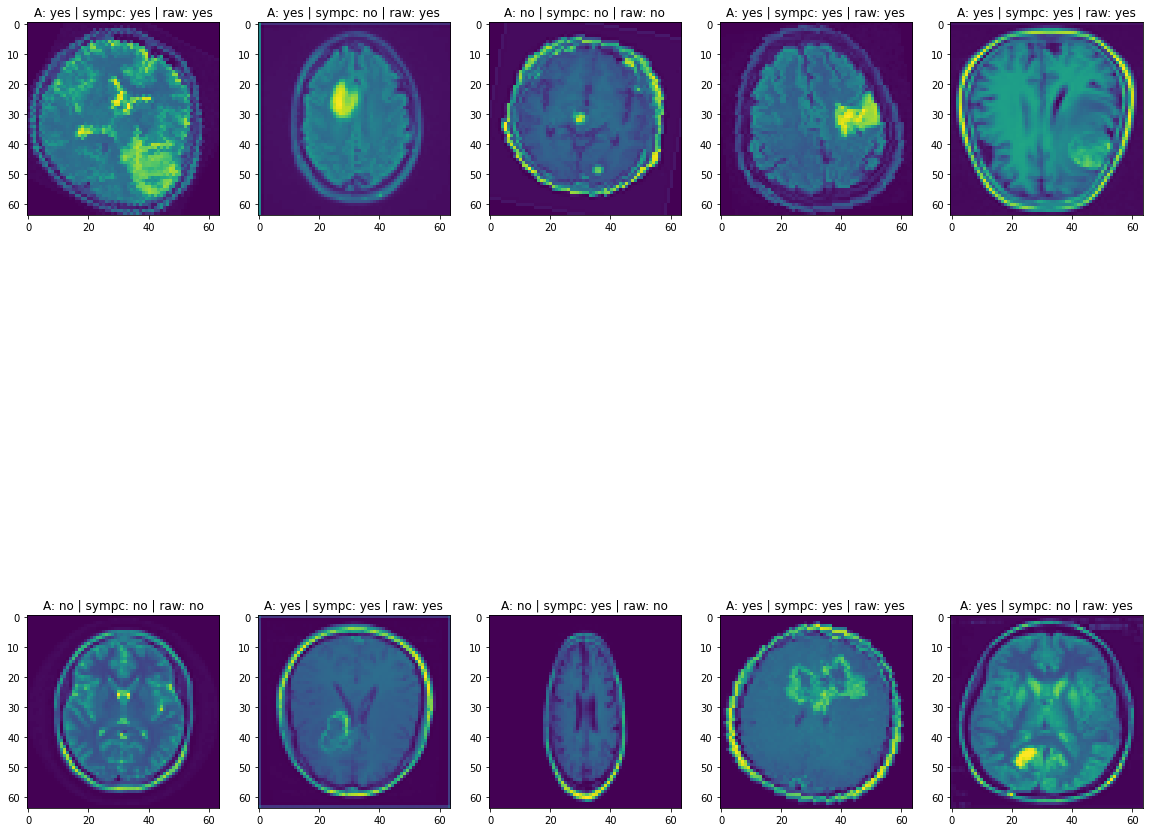

Time for inference: 1067.440476179123
Succes rate (sympc pred/actual labels):  0.78
Succes rate (sympc pred/raw pred):  0.78


In [23]:
fig = plt.figure(figsize=(20,20))
iter_loader = iter(plot_loader)
succes_sympc_overal = 0
succes_sympc_raw = 0
for i in range(10):
    img, label = next(iter_loader)
    pred = results[i]
    raw_pred = raw_predictions[i]
    target = labels[i]
    pred = torch.argmax(pred, dim=1)
    plt.subplot(2,5,i+1)
    plt.imshow(img[0][0])
    plt.title(f"A: {mapping[target.detach().item()]} | " +
              f"sympc: {mapping[pred.detach().item()]} | " +
              f"raw: {mapping[raw_pred.detach().item()]}")
    if pred == label: succes_sympc_overal += 1
    if pred == raw_pred: succes_sympc_raw += 1
    
plt.show()
print(f"Time for inference: {end_time - start_time}")
print(f"Succes rate (sympc pred/actual labels): {succes_sympc_overal/i: .2f}")
print(f"Succes rate (sympc pred/raw pred): {succes_sympc_raw/i: .2f}")

### advanced split data

In [26]:

imgs, lbls = next(iter(plot_loader))
data_to_split = []
for i, batch in enumerate(plot_loader):
    if i == 8: break
    img, lbl = batch
#     print(img)
    data_to_split.append(img)

print(len(data_to_split))


8


<ipython-input-2-2e16d5b9921f>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(array)


In [31]:
dts_tensor = torch.tensor(data_to_split)
dts_tensor.shape

ValueError: only one element tensors can be converted to Python scalars

In [30]:
a_ptrs = split_send(data_to_split, session=session)

a_ptrs

AttributeError: 'list' object has no attribute 'shape'

In [27]:
import time
start_time = time.time()

a_results = []

for ptr in a_ptrs:
    a_encrypted_results = mpc_model(ptr)
    print(f"encrypted results: {a_encrypted_results}")
    a_plaintext_results = a_encrypted_results.reconstruct()
    print(f"plain text results: {a_plaintext_results}")
    a_results.append(a_plaintext_results)

end_time = time.time()
a_results

RuntimeError: [enforce fail at CPUAllocator.cpp:67] . DefaultCPUAllocator: can't allocate memory: you tried to allocate 7695380480 bytes. Error code 12 (Cannot allocate memory)

In [ ]:
fig = plt.figure(figsize=(20,20))
for i in range(20):
    pred = results[i]
    target = labels[i]
    pred = torch.argmax(pred, dim=1)
    plt.subplot(4,5,i+1)
    plt.imshow(dataset[i][0][0][0])
    plt.title(f'Actual: {mapping[target.detach().item()]} Predicted: {mapping[pred.detach().item()]}')
plt.show()
print(f"Time for inference: {end_time - start_time}")

TypeError: share() missing 1 required positional argument: 'session'